In [860]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing
import xgboost as xgb
import scipy as sp
from sklearn.metrics import  make_scorer
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression

In [861]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [862]:
print train.shape, test.shape

(891, 12) (418, 11)


In [863]:
Y_train = train.Survived
test_id = test.PassengerId

In [864]:
train_test = pd.concat([train, test])
train_test = train_test.drop(['PassengerId', 'Survived', 'Name', 'Cabin', 'Ticket'], axis = 1)
print 'shape: '
print train_test.shape, train.shape, test.shape
print '~~~~~~~~~~~~~'
print 'type'
print train_test.dtypes
print '~~~~~~~~~~~~~'
print 'No. of Nans'
print train_test.isnull().sum()
print '~~~~~~~~~~~~~'
train_test.head(2)

shape: 
(1309, 7) (891, 12) (418, 11)
~~~~~~~~~~~~~
type
Age         float64
Embarked     object
Fare        float64
Parch         int64
Pclass        int64
Sex          object
SibSp         int64
dtype: object
~~~~~~~~~~~~~
No. of Nans
Age         263
Embarked      2
Fare          1
Parch         0
Pclass        0
Sex           0
SibSp         0
dtype: int64
~~~~~~~~~~~~~


,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp
0,22.0,S,7.2500,0,3,male,1
1,38.0,C,71.2833,0,1,female,1


In [865]:
print 'fill NaNs with mean or mode for object type'
train['Age'].fillna((train['Age'].mean()), inplace=True)
train['Fare'].fillna((train['Fare'].mean()), inplace=True)
train['Embarked'].fillna((train.Embarked.value_counts()[0]), inplace=True)
test['Age'].fillna((test['Age'].mean()), inplace=True)
test['Fare'].fillna((test['Fare'].mean()), inplace=True)
test['Embarked'].fillna((test.Embarked.value_counts()[0]), inplace=True)
train_test = pd.concat([train, test])
train_test = train_test.drop(['PassengerId', 'Survived', 'Name', 'Cabin', 'Ticket'], axis = 1)

print 'No. of Nans'
print train_test.isnull().sum()
train_test.head(2)

fill NaNs with mean or mode for object type
No. of Nans
Age         0
Embarked    0
Fare        0
Parch       0
Pclass      0
Sex         0
SibSp       0
dtype: int64


,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp
0,22.0,S,7.2500,0,3,male,1
1,38.0,C,71.2833,0,1,female,1


In [866]:
print 'process object types: ["Embarked", "Sex"]'
train_test['Embarked'] = train_test['Embarked'].factorize()[0]
train_test = pd.concat([train_test, pd.get_dummies(train_test.Sex)], axis = 1)
train_test = train_test.drop(['Sex'], axis = 1)
print train_test.dtypes
train_test.head()

process object types: ["Embarked", "Sex"]
Age         float64
Embarked      int64
Fare        float64
Parch         int64
Pclass        int64
SibSp         int64
female        uint8
male          uint8
dtype: object


,Age,Embarked,Fare,Parch,Pclass,SibSp,female,male
0,22.0,0,7.2500,0,3,1,0,1
1,38.0,1,71.2833,0,1,1,1,0
2,26.0,0,7.9250,0,3,0,1,0
3,35.0,0,53.1000,0,1,1,1,0
4,35.0,0,8.0500,0,3,0,0,1


In [867]:
train_test.describe()

,Age,Embarked,Fare,Parch,Pclass,SibSp,female,male
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,29.882243,0.398778,33.297261,0.385027,2.294882,0.498854,0.355997,0.644003
std,12.883758,0.661200,51.738919,0.865560,0.837836,1.041658,0.478997,0.478997
min,0.170000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,7.895800,0.000000,2.000000,0.000000,0.000000,0.000000
50%,29.699118,0.000000,14.454200,0.000000,3.000000,0.000000,0.000000,1.000000
75%,35.000000,1.000000,31.275000,0.000000,3.000000,1.000000,1.000000,1.000000
max,80.000000,3.000000,512.329200,9.000000,3.000000,8.000000,1.000000,1.000000


In [868]:
def normalize(columns):
    for col in columns:
        mu = train[col].mean()
        sigma = train[col].std()
        train_test[col] = (train[col] - train[col].mean())/train[col].std()

In [869]:
print 'normalize columns ["Age", "Fare"]: '
columns_to_normalize = ['Age', 'Fare']
normalize(columns_to_normalize)
train_test.describe()

normalize columns ["Age", "Fare"]: 


,Age,Embarked,Fare,Parch,Pclass,SibSp,female,male
count,1.309000e+03,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,-2.006238e-02,0.398778,0.002039,0.385027,2.294882,0.498854,0.355997,0.644003
std,9.919921e-01,0.661200,0.997283,0.865560,0.837836,1.041658,0.478997,0.478997
min,-2.251891e+00,0.000000,-0.648058,0.000000,1.000000,0.000000,0.000000,0.000000
25%,-5.921480e-01,0.000000,-0.488580,0.000000,2.000000,0.000000,0.000000,0.000000
50%,4.371893e-15,0.000000,-0.357190,0.000000,3.000000,0.000000,0.000000,1.000000
75%,4.076970e-01,1.000000,-0.024233,0.000000,3.000000,1.000000,1.000000,1.000000
max,3.868699e+00,3.000000,9.661740,9.000000,3.000000,8.000000,1.000000,1.000000


In [870]:
X_train = train_test[:len(train)]
X_test = train_test[len(train):]
print X_train.shape, X_test.shape

(891, 8) (418, 8)


In [871]:
def sigmoid(x):
    x = np.array(x)
    return 1/(1+np.exp(-x))

In [872]:
def logistic_regression_model(X_train, Y_train, theta, la):
    # return cost J and gradient of theta in grad
    m = len(Y_train)
    X = X_train.copy()
    X.insert(0, 'Bias', 1)
    X = np.array(X)
    Y = np.array(Y_train)
    h_theta = sigmoid(np.dot(X, theta))
    J = -(np.dot(Y, np.log(h_theta)) + np.dot(1-Y, np.log(1-h_theta))) / m + np.dot(theta[1:], theta[1:]) *la / (2*m)
    grad = np.dot(X.transpose(), h_theta - Y) / m + theta*la / m
    grad[0] = grad[0] - theta[0]*la / m     
    return [J, grad]

In [873]:
def logistic_regression_train(X_train, Y_train, theta, grad, la, alpha, epsilon, max_iterators):
    # return cost J and optimal theta 
    [J, grad] = logistic_regression_model(X_train, Y_train, theta, la)
    cost = [J]
    for i in range(max_iterators):
        theta = theta - alpha * grad
        [J, grad] = logistic_regression_model(X_train, Y_train, theta, la)
        if cost[-1] - J < epsilon:
            break
        cost.append(J)
        
    plt.plot(cost)
    plt.xlabel('No. of iterations')
    plt.ylabel('Cost function J')
    plt.show()
    
    return [J, theta]

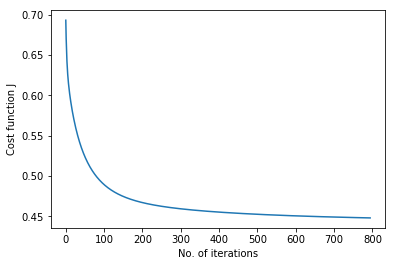

In [874]:
la = 1
alpha = 0.1
epsilon = 10.0**(-5)
max_iterators = 1000
init_theta = np.zeros(X_train.shape[1] + 1)
[J, theta] = logistic_regression_train(X_train, Y_train, init_theta, grad, la, alpha, epsilon, max_iterators)

In [875]:
def logistic_regression_predict(theta, X_test):
    X = X_test.copy()
    X.insert(0, 'Bias', 1)
    X = np.array(X)
    predict = sigmoid(np.dot(X, theta))
    return predict

In [887]:
print 'predict result:'
predict = logistic_regression_predict(theta, X_test)
y_predict = [1 if p > 0.5 else 0 for p in predict]
print len(test_id), len(y_predict)
output = pd.DataFrame({'PassengerId': test_id, 'Survived': y_predict})
output.to_csv('Titanic_03-11-2018.csv', index=False)
output.head()

predict result:
418 418


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
